# DSP - EQ Shelving in Python and using NumPy

Author: rasmushyldgaard <br />
Date: 20-05-2023

In [18]:
import numpy as np
from numpy.fft import fft, ifft
import matplotlib.pyplot as plt

from shelving import shelving_filter

plt.style.use('dark_background')

### 0. Helperfunctions 

In [29]:
def first_order_shelving_filter(gain: int,
                                fc: int,
                                fs: int,
                                Nfft: int,
                                mode: str = 'low' or 'high',
                                filtering=False):
    """Returns coefficients for filtering or transfer function for 1st order shelving filters"""
    if mode != 'low' and mode != 'high':
        print("Shelving mode is not recognized! Please use either 'low' or 'high'...")
        exit(1)
        
    # filter coefficients
    b, a = shelving_filter(gain=gain,
                           fc=fc,
                           fs=fs,
                           mode=mode)
    
    # if coeff's are needed for filtering a signal
    if filtering:
        return b, a
    else:
        # transfer function, H(f)
        return fft(b, Nfft) / fft(a, Nfft)
    
    
def second_order_shelving_filter(gain_low: int,
                                 gain_high: int,
                                 fc_low: int,
                                 fc_high: int,
                                 fs: int,
                                 Nfft: int,
                                 filtering=False):
    """Returns coefficients for filtering or transfer function for 2nd order shelving filters"""
    
    # if coeff's are needed for filtering
    if filtering:
        b_low, a_low = first_order_shelving_filter(gain=gain_low,
                                                   fc=fc_low,
                                                   fs=fs,
                                                   Nfft=Nfft,
                                                   mode='low',
                                                   filtering=True)
        b_high, a_high = first_order_shelving_filter(gain=gain_high,
                                                     fc=fc_high,
                                                     fs=fs,
                                                     Nfft=Nfft,
                                                     mode='high',
                                                     filtering=True)
        
        # convolve b's and a's -> equivalent to polynomium multiplication in complex domain
        b = np.convolve(b_low, b_high)
        a = np.convolve(a_low, a_high)
        return b, a
        
    else:
        # transfer function for `low` shelf
        H_low = first_order_shelving_filter(gain=gain_low,
                                            fc=fc_low,
                                            fs=fs,
                                            Nfft=Nfft,
                                            mode='low')
    
        # transfer function for `high` shelf
        H_high = first_order_shelving_filter(gain=gain_high,
                                             fc=fc_high,
                                             fs=fs,
                                             Nfft=Nfft,
                                             mode='high')
        # H(z) = H_low(z)*H_high(z)
        return H_low * H_high


def tf_scaler(H: np.array):
    return 20*np.log10(np.absolute(H))

### 1. Creating and plotting 1st order shelving filters

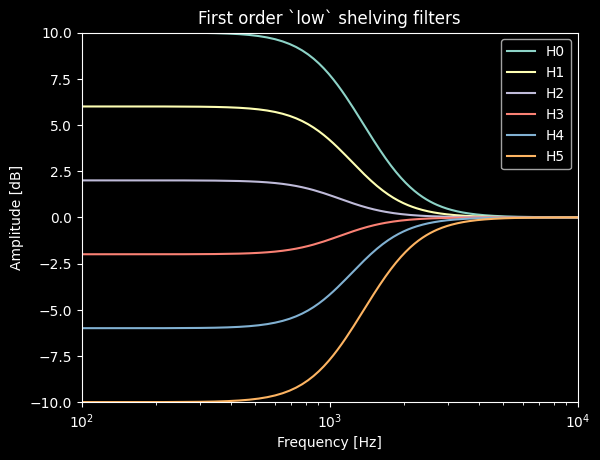

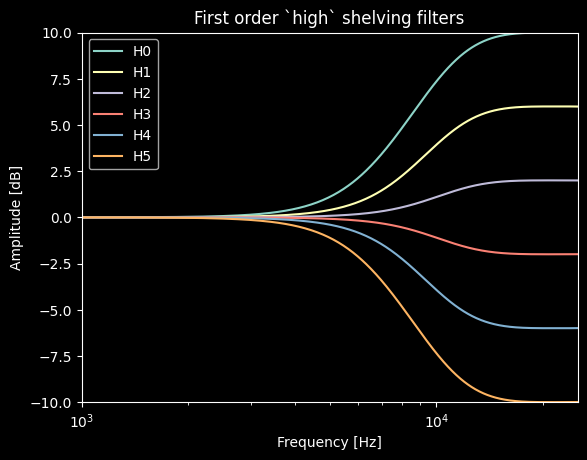

In [20]:
fs = 44100                                     # standard audio sampling frequency at 44.1 kHz
Nfft = 1024                                    # 1024-point DFT
k = np.linspace(start=1, stop=Nfft, num=Nfft)  # frequency bins
f = k*fs / Nfft                                # frequency axis
number_of_filters = 6

# first order `low` shelving filters
fc = 1000                                      # cutoff freq at 1 kHz
gains = np.array([10, 6, 2, -2, -6, -10])
mode = 'low'
legends = []
for filt in range(number_of_filters):
    filter_name = "H" + str(filt)
    legends.append(filter_name)
    tf = first_order_shelving_filter(gain=gains[filt],
                                     fc=fc,
                                     fs=fs,
                                     Nfft=Nfft,
                                     mode=mode)
    tf = tf_scaler(tf)
    plt.semilogx(f, tf)
    
plt.title("First order `low` shelving filters")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Amplitude [dB]")
plt.legend(legends)
plt.xlim(10e1, 10e3)
plt.ylim(-10, 10)
plt.show();

# first order `high` shelving filters
fc = 10000                                    # cutoff freq at 10 kHz
mode = 'high'
legends = []
for filt in range(number_of_filters):
    filter_name = "H" + str(filt)
    legends.append(filter_name)
    tf = first_order_shelving_filter(gain=gains[filt],
                                     fc=fc,
                                     fs=fs,
                                     Nfft=Nfft,
                                     mode=mode)
    tf = tf_scaler(tf)
    plt.semilogx(f, tf)

plt.title("First order `high` shelving filters")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Amplitude [dB]")
plt.legend(legends)
plt.xlim((10e2, 25000))
plt.ylim(-10, 10)
plt.show();

### 2. Creating and plotting 1st order shelving filters at different cutoff's

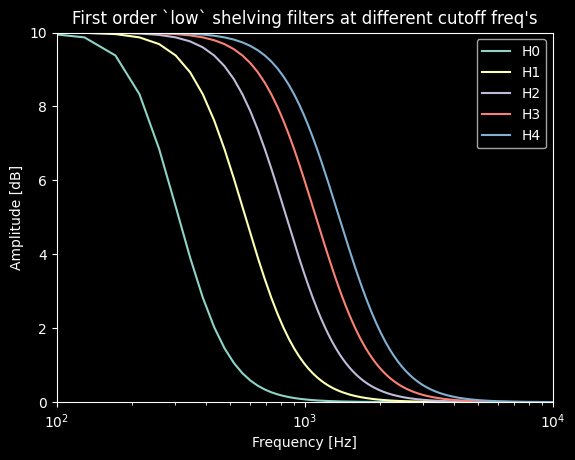

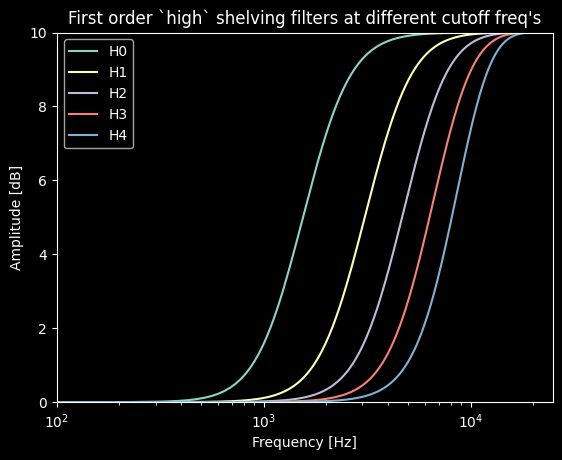

In [21]:
number_of_filters = 5
gain = 10
fc_low = np.array([200, 400, 600, 800, 1000])
fc_high = np.array([2000, 4000, 6000, 8000, 10000])

legends = []
for filt in range(number_of_filters):
    filter_name = "H" + str(filt)
    legends.append(filter_name)
    tf = first_order_shelving_filter(gain=gain,
                                     fc=fc_low[filt],
                                     fs=fs,
                                     Nfft=Nfft)
    tf = tf_scaler(tf)
    plt.semilogx(f, tf)

plt.title("First order `low` shelving filters at different cutoff freq's")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Amplitude [dB]")
plt.legend(legends)
plt.xlim(10e1, 10e3)
plt.ylim(0, 10)
plt.show();

legends = []
for filt in range(number_of_filters):
    filter_name = "H" + str(filt)
    legends.append(filter_name)
    tf = first_order_shelving_filter(gain=gain,
                                     fc=fc_high[filt],
                                     fs=fs,
                                     Nfft=Nfft,
                                     mode='high')
    tf = tf_scaler(tf)
    plt.semilogx(f, tf)
    
plt.title("First order `high` shelving filters at different cutoff freq's")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Amplitude [dB]")
plt.legend(legends)
plt.xlim(10e1, 25000)
plt.ylim(0, 10)
plt.show();

### 3. Creating and plotting 2nd order shelving filters

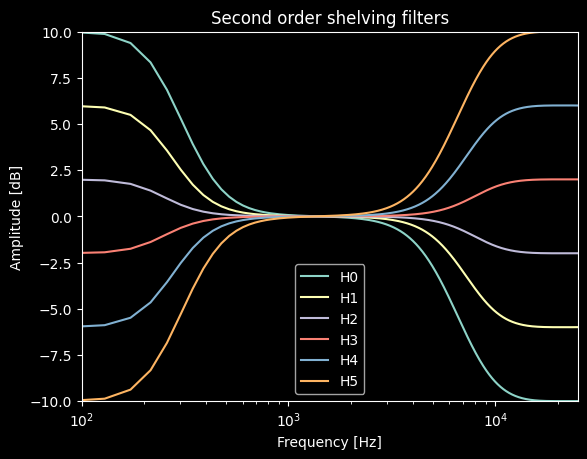

In [22]:
gains_low = np.array([10, 6, 2, -2, -6, -10])
gains_high = np.flip(gains_low, axis=0)
fc_low = 200
fc_high = 8000
number_of_filters = 6

legends = []
for filt in range(number_of_filters):
    filter_name = "H" + str(filt)
    legends.append(filter_name)
    tf = second_order_shelving_filter(gain_low=gains_low[filt],
                                      gain_high=gains_high[filt],
                                      fc_low=fc_low,
                                      fc_high=fc_high,
                                      fs=fs,
                                      Nfft=Nfft)
    tf = tf_scaler(tf)
    plt.semilogx(f, tf)
    
plt.title("Second order shelving filters")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Amplitude [dB]")
plt.legend(legends)
plt.xlim(10e1, 25000)
plt.ylim(-10, 10)
plt.show();

### 4. Creating and plotting 2nd order shelving filters at different cutoff's

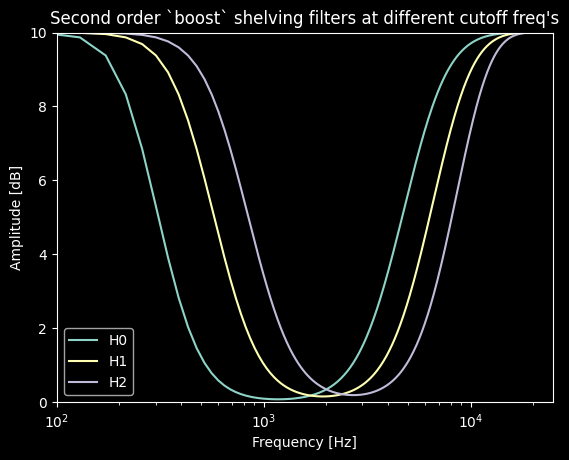

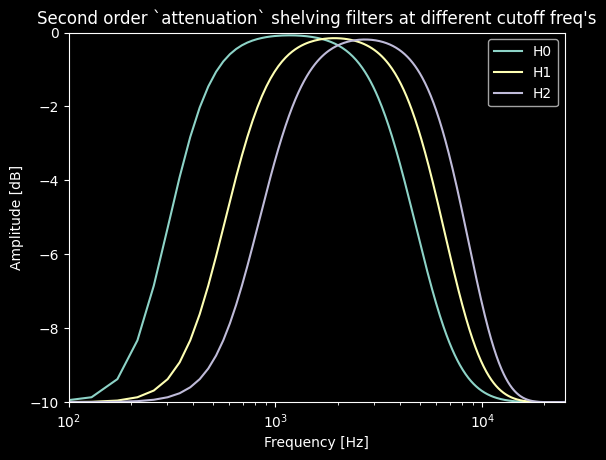

In [23]:
fc_low = np.array([200, 400, 600])
fc_high = np.array([6000, 8000, 10000])
number_of_filters = 3

# 2nd order shelving with boost in both 'low' and 'high' frequencies
gain = 10
legends = []
for filt in range(number_of_filters):
    filter_name = "H" + str(filt)
    legends.append(filter_name)
    tf = second_order_shelving_filter(gain_low=gain,
                                      gain_high=gain,
                                      fc_low=fc_low[filt],
                                      fc_high=fc_high[filt],
                                      fs=fs,
                                      Nfft=Nfft)
    tf = tf_scaler(tf)
    plt.semilogx(f, tf)

plt.title("Second order `boost` shelving filters at different cutoff freq's")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Amplitude [dB]")
plt.legend(legends)
plt.xlim(10e1, 25000)
plt.ylim(0, 10)
plt.show();

# 2nd order shelving with attenuation in both 'low' and 'high' frequencies
gain = -10
legends = []
for filt in range(number_of_filters):
    filter_name = "H" + str(filt)
    legends.append(filter_name)
    tf = second_order_shelving_filter(gain_low=gain,
                                      gain_high=gain,
                                      fc_low=fc_low[filt],
                                      fc_high=fc_high[filt],
                                      fs=fs,
                                      Nfft=Nfft)
    tf = tf_scaler(tf)
    plt.semilogx(f, tf)

plt.title("Second order `attenuation` shelving filters at different cutoff freq's")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Amplitude [dB]")
plt.legend(legends)
plt.xlim(10e1, 25000)
plt.ylim(-10, 0)
plt.show();

### 5. Create white noise signal and apply EQ shelving using SciPy

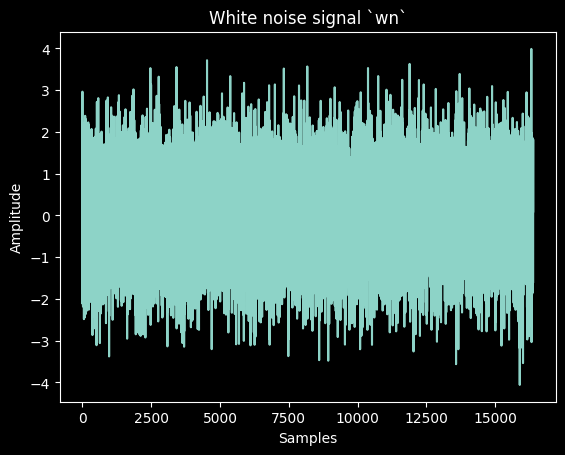

In [24]:
from scipy.signal import lfilter
from numpy.random import normal

# white noise signal contains all of the frequencies across the audible sound spectrum
mean = 0
std = 1
Nfft = 16384
wn = np.random.normal(mean, std, size=Nfft)
plt.plot(wn)

# plot white noise signal
plt.title("White noise signal `wn`")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show();

#### 5.1 Plotting frequency spectrum of white noise signal

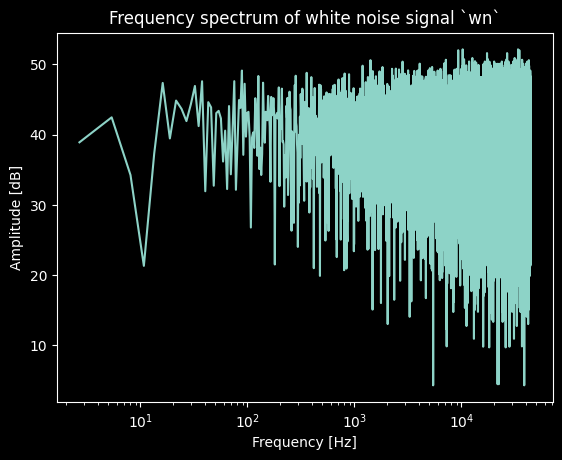

In [25]:
k = np.linspace(start=1, stop=Nfft, num=Nfft)  
f = k*fs / Nfft   
WN = fft(wn, Nfft)
WN_scaled = tf_scaler(WN)

plt.semilogx(f, WN_scaled)
plt.title("Frequency spectrum of white noise signal `wn`")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Amplitude [dB]")
plt.show();

#### 5.2 Apply low shelving on white noise signal with 1st order shelving filter

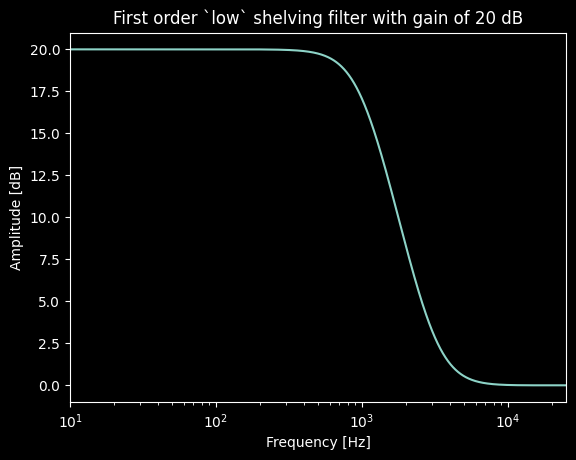

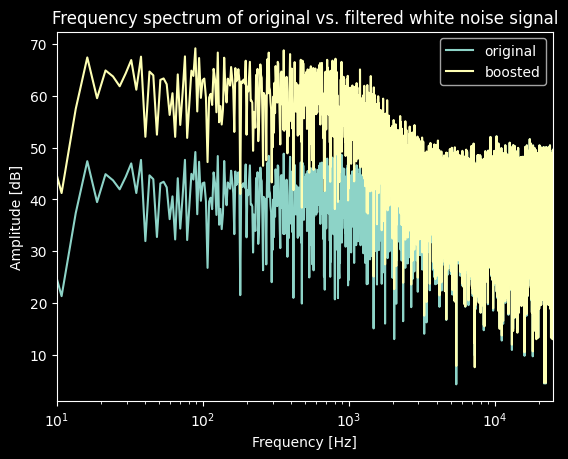

In [26]:
gain = 20
fc = 1000

tf = first_order_shelving_filter(gain=gain,
                                 fc=fc,
                                 fs=fs,
                                 Nfft=Nfft,
                                 mode='low')
tf_scaled = tf_scaler(tf)

# plot `low` shelving filter
plt.semilogx(f, tf_scaled)
plt.title("First order `low` shelving filter with gain of 20 dB")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Amplitude [dB]")
plt.xlim(10e0, 25000)
plt.show();


# apply `low` shelving on white noise signal
b, a = first_order_shelving_filter(gain=gain,
                                   fc=fc,
                                   fs=fs,
                                   Nfft=Nfft,
                                   mode='low',
                                   filtering=True)
filtered_wn = lfilter(b, a, wn)

# plot frequency spectrum of filtered white noise signal
filtered_WN = fft(filtered_wn, Nfft)
filtered_WN_scaled = tf_scaler(filtered_WN)

plt.semilogx(f, WN_scaled)
plt.semilogx(f, filtered_WN_scaled)
plt.title("Frequency spectrum of original vs. filtered white noise signal")
plt.legend(['original', 'boosted'])
plt.xlabel("Frequency [Hz]")
plt.ylabel("Amplitude [dB]")
plt.xlim(10e0, 25000)
plt.show();

#### 5.3 Apply high shelving on white noise signal with 1st order shelving filter

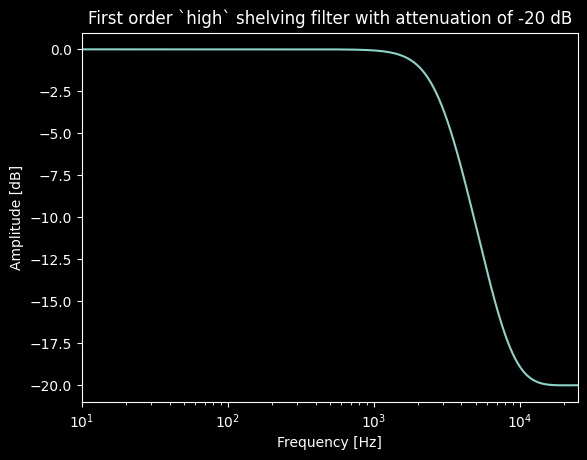

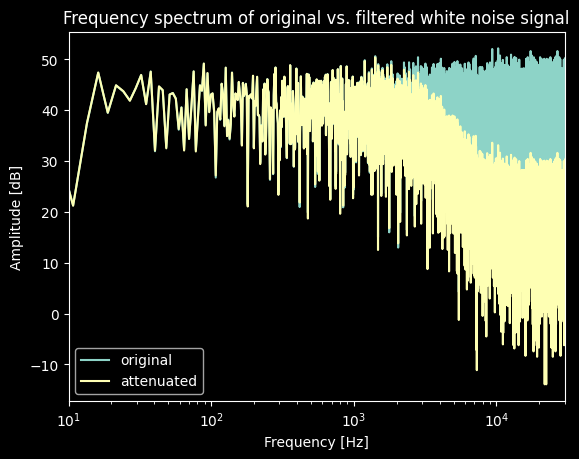

In [27]:
gain = -20
fc = 8000

tf = first_order_shelving_filter(gain=gain,
                                 fc=fc,
                                 fs=fs,
                                 Nfft=Nfft,
                                 mode='high')
tf_scaled = tf_scaler(tf)

# plot `low` shelving filter
plt.semilogx(f, tf_scaled)
plt.title("First order `high` shelving filter with attenuation of -20 dB")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Amplitude [dB]")
plt.xlim(10e0, 25000)
plt.show();


# apply `high` shelving on white noise signal
b, a = first_order_shelving_filter(gain=gain,
                                   fc=fc,
                                   fs=fs,
                                   Nfft=Nfft,
                                   mode='high',
                                   filtering=True)
filtered_wn = lfilter(b, a, wn)

# plot frequency spectrum of filtered white noise signal
filtered_WN = fft(filtered_wn, Nfft)
filtered_WN_scaled = tf_scaler(filtered_WN)

plt.semilogx(f, WN_scaled)
plt.semilogx(f, filtered_WN_scaled)
plt.title("Frequency spectrum of original vs. filtered white noise signal")
plt.legend(['original', 'attenuated'])
plt.xlabel("Frequency [Hz]")
plt.ylabel("Amplitude [dB]")
plt.xlim(10e0, 30000)
plt.show();

#### 5.4 Apply 2nd order shelving filter with boost in low frequencies and attenuation in high frequencies

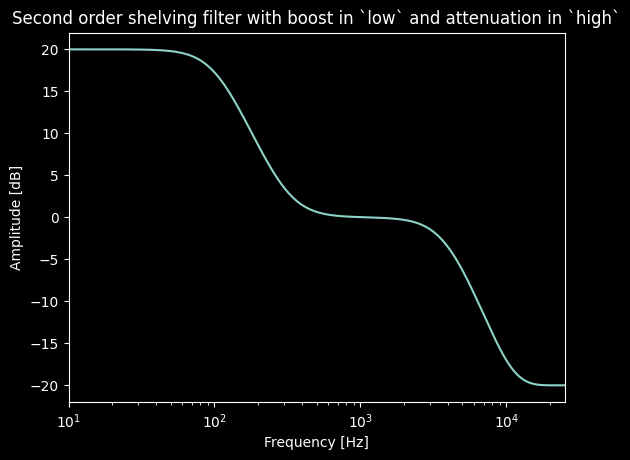

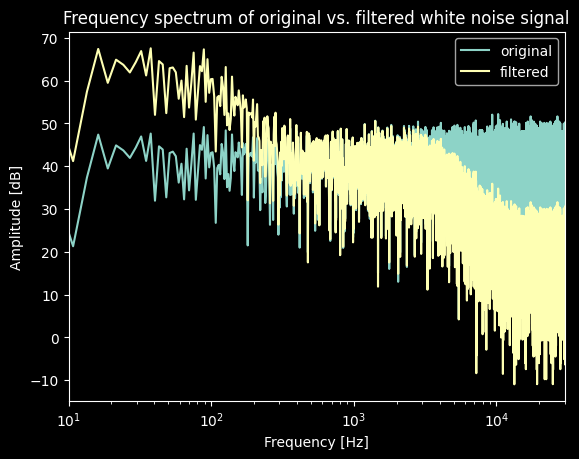

In [28]:
gain_low = 20
gain_high = -20
fc_low = 100
fc_high = 10000

tf = second_order_shelving_filter(gain_low=gain_low,
                                  gain_high=gain_high,
                                  fc_low=fc_low,
                                  fc_high=fc_high,
                                  fs=fs,
                                  Nfft=Nfft)
tf_scaled = tf_scaler(tf)

# plot 2nd order shelving filter
plt.semilogx(f, tf_scaled)
plt.title("Second order shelving filter with boost in `low` and attenuation in `high`")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Amplitude [dB]")
plt.xlim(10e0, 25000)
plt.show();

# apply 2nd order shelving filter to white noise signal
b, a = second_order_shelving_filter(gain_low=gain_low,
                                    gain_high=gain_high,
                                    fc_low=fc_low,
                                    fc_high=fc_high,
                                    fs=fs,
                                    Nfft=Nfft,
                                    filtering=True)
filtered_wn = lfilter(b, a, wn)

# plot frequency spectrum of filtered white noise signal
filtered_WN = fft(filtered_wn, Nfft)
filtered_WN_scaled = tf_scaler(filtered_WN)

plt.semilogx(f, WN_scaled)
plt.semilogx(f, filtered_WN_scaled)
plt.title("Frequency spectrum of original vs. filtered white noise signal")
plt.legend(['original', 'filtered'])
plt.xlabel("Frequency [Hz]")
plt.ylabel("Amplitude [dB]")
plt.xlim(10e0, 30000)
plt.show();